In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.stats as stats
from typing import Tuple
from pandas.plotting import parallel_coordinates
from models import logistic_regression, random_forest, xgboost
from analysis import scree_plot, two_variable_pca, t_sne
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 6, 4
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

# Introduction

Our work seeks to curate audio features to train a music genre classifier. Such a classifier would be able to take in a set of audio features for a song and accurately determine the genre of that song--a task that is accomplished by most humans with minimal background in music. There are a number of difficulties in such a problem not limited to the definition of "genre" and selecting appropriate audio to train the model.

## Motivation

It is a somewhat simple task for a trained musician or musicologist to listen to a work of music and label its genre. What do we need to help a computer complete the same task? Questions we want to answer:

1. What features of music make it a part of its genre?
2. Is genre classification a problem well-suited to classical machine learning?

We hypothesize that the MFCC coefficients will be important, because others doing genre classification have found them important, at least in deep learning models. We think that taking the mean and variance of the coefficients for each song will retain the most important information while making the problem tractable.

We would note that one difficulty related to this task relates to how we define genres.  It is a very abstract and subjective question, and the lines between genres are blurry at best. Thus, any machine learning genre classifier will be subject to the issue of vague class divisions depending on who labelled the data and what metric they used.

## Related Work

There have been many studies in the area of genre classification in machine learning. Traditionally models have used learning algorithms for SVM and KNN and have relied heavily on common spectral features including the MFCCs (1). The state of the art has improved over time with most classical machine learning classifiers managing 60-70% accuracy. This is similar to human capabilities with short song intervals according to some human trials (2). In more recent years, neural networks have been able to make more accurate predictions near 80-90% accuracy in some cases.

# Data

Our data comes from the Free Music Archive (https://github.com/mdeff/fma) created by Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson. International Society for Music Information Retrieval Conference (ISMIR), 2017.

We use the audio files and genre tags, but build our own features. We also use the small data set composed of 8000 30-second songs (8 GB in `.mp3` fromat). We convert each file to a `.wav` for simplicity. Each song is designated by a `track_id` and labeled with one of eight genres: Hip-Hop, Pop, Folk, Experimental, Rock, International, Electronic, and Instrumental. There songs are distributed evenly across genres with 1000 songs per genre.

## Potential Issues

One potential issue with our data is that the dataset is composed entirely of free music (creative commons), and therefore our model may have difficulty analyzing other kinds of music, which may be quite different.

Specifically, we have reason to believe that the genre definitions, quality, and style of a free music database may differ from commercial music, so a future step could be finding a way to evaluate how well a model trained on a free music database can generalize to samples of commercial music.

## Missing Data

The dataset is fairly robust, but of the 8000 tracks, there are 6 that are only a few seconds long. We ignore these tracks from our analysis, since our algorithms for feature extraction depend on the songs being of a certain length in order to be accurate.

## Ethical Concerns and Implications

The music used in our work comes from the Creative Commons and is liscensed for this kind of use. We see no privacy concerns with the collection of this data. As music genre does not make a serious impact on the commercialization of music or the daily lives of non-musicians, we do not anticipate any negative repercussions from our work. The lines around genre are vague enough to ensure that professors of music theory and music history need not worry that they shall be out of a job.

# Feature Engineering

Since our original data was made up only of track IDs corresponding to wav files, and their genre labels, our feature extraction makes up all of our useful data. We created a dataframe that has the following features as its columns. In the next section, we discuss the meaning of each added feature column.

## Feature Descriptions and Reasoning

**Track ID**: each wav file corresponds to a number, and we have a function that generates the file path to access each track if needed.
Genre Code: We have encoded our eight genres by a 1:1 mapping to integers 0-7.

**Mel Frequency Cepstral Coefficients (MFCCs)**: Represents the short term power spectrum of the sound. Aligns closely with the human auditory system’s reception of sound. These 30 coefficients describe the sound of a song in a human way. MFCCs are being used more and more in Music Information Retrieval specifically with genre tasks because they encapsulate the human experience of sound. We feel this will improve accuracy.

**Zero Crossing Rate**: Indicates the average rate at which the sign of the signal changes. Higher zero crossing rates match with higher percussiveness in the song. We added this feature because genres often have a certain feel relative to beat and percussive sound.

**Frequency Range**: The max and min frequency the audio ignoring the top 20% and bottom 20%. Clipping the top and bottom was important because almost all of our audio files go from 10 Hz to 10000 Hz. But seeing the range in where most of the sound of a song is seems to be connected to genre. Some genres have greater ranges while others are in a small range.

**Key and Tonality**: We used the Krumhansl-Schmuckler algorithm to estimate the most likely key that the audio sample is in, and whether the key is major or minor. We chose this because even though most genres have songs in different keys, knowing the key will aid in normalizing pitch information for other features.

**Spectral Rolloff**: The frequency below which a certain percent of the total spectral energy (pitches) are contained. When audio signals are noisy, the highest and lowest pitches present do not convey much information. What is more useful is knowing the frequency range that 99% of the signal is contained in, which is what the spectral rolloff represents.

**The Three Highest Tempo Autocorrelation Peaks**: Indicative of what we would guess the average BPM will be for this audio file (3 columns).  This is a way of summing up the entire tempogram array in just a few numbers so that comparing tempo features for each track is tractable.

**Average Tonnetz over all Time**: The mean and variance of the x and y dimensions of the tonal centers for the major and minor thirds, as well as the fifths (this ends up being 6 means and 6 variances for a total of 12 columns).  Here we take the means and variances to reduce the information down from a 6xt matrix (where t is the number of time values, about 1200) to just 12 numbers that sum up that matrix for each track.

We have included the following code as an example of our feature engineering; we defined a lot of functions for our feature engineering that we don't have space here to include. The full code can be found at https://github.com/clarkedb/motif and in our supplementary files.

```python
# coefficients from: http://rnhart.net/articles/key-finding/
major_coeffs = la.circulant(
    stats.zscore(
        np.array(
            [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
        )
    )
).T
minor_coeffs = la.circulant(
    stats.zscore(
        np.array(
            [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
        )
    )
).T

def find_key(y: np.ndarray, sr: int) -> Tuple[bool, int]:
    """
    Estimate the major or minor key of the input audio sample
    :param y: np.ndarray [shape=(n,)]
    Audio time series
    :param sr: number > 0
    Sampling rate of y
    :return: (bool, int)
    Whether the sample is in a major key (as opposed to a minor key)
    Key of the audio sample
    """
    # compute the chromagram of the audio sample
    chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

    # find the average of each pitch over the entire audio sample
    average_pitch = chroma_cq.mean(axis=1)

    # Krumhansl-Schmuckler algorithm (key estimation)
    x = stats.zscore(average_pitch)
    major_corr, minor_corr = major_coeffs.dot(x), minor_coeffs.dot(x)
    major_key, minor_key = major_corr.argmax(), minor_corr.argmax()

    # determine if the key is major or minor
    is_major = major_corr[major_key] > minor_corr[minor_key]

    return is_major, major_key if is_major else minor_key
```

# Visualization and Analysis

## Visualization

In [2]:
genres = [
    "Hip-Hop",
    "Pop",
    "Folk",
    "Experimental",
    "Rock",
    "International",
    "Electronic",
    "Instrumental",
]

df = pd.read_csv('../data/features.csv', header=0)
df['genre'] = df.genre_code.apply(lambda x : genres[x])

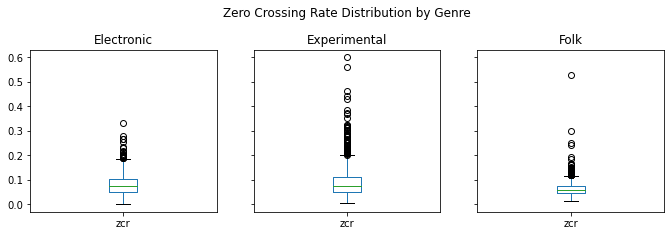

In [3]:
df[df.genre.isin(['Electronic', 'Experimental', 'Folk'])][['zcr', 'genre']].groupby('genre').boxplot(column='zcr', grid=False, layout=(1,3), figsize=(11,3))
plt.suptitle('Zero Crossing Rate Distribution by Genre', y=1.1)
plt.show()

These boxplots show the Zero Crossing Rate distribution by genre. ZCR is usually thought of as a good measure to include when doing a genre analysis because it conveys something of the percusiveness of the song. We see that the distributions differ enought to justify including it, but some genres are more drastic than others.

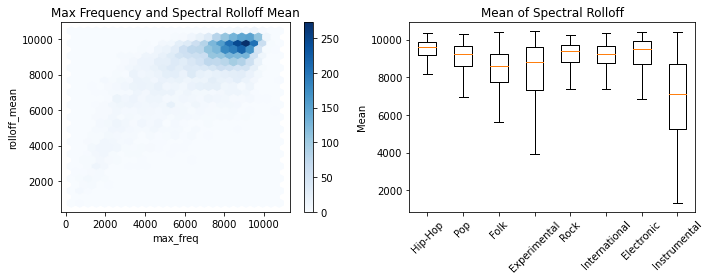

In [4]:
fig, ax = plt.subplots(1, 2)

df.plot(ax=ax[0], kind='hexbin', x='max_freq', y='rolloff_mean', gridsize=25, figsize=(7, 5), cmap='Blues', sharex=False)
ax[0].set_title('Max Frequency and Spectral Rolloff Mean')

rolloff_mean = df["rolloff_mean"]

ax[1].boxplot(np.array([
    rolloff_mean[df["genre_code"] == i] for i in range(len(genres))
], dtype=object), labels=genres, showfliers=False)
ax[1].set_title("Mean of Spectral Rolloff")
ax[1].set_ylabel("Mean")
ax[1].set_xticklabels(labels=genres, rotation=45)
fig.set_size_inches((10, 4))
plt.tight_layout()
plt.show()

The hexbin plot (left) compares the max frequency and the spectrall rolloff mean. Because the spectral rolloff mean is the mean frequency greater than 99% of a time frame's frequencies, it make sense that it may be redundant information or colinear with max_frequency. 

A couple things to note from the mean of spectral rolloff plot (right) are the distributions of the mean spectral rolloff of experimental and instrumental music, which tend to be skewed lower than for other genres. Note that we omitted outliers from the boxplot.

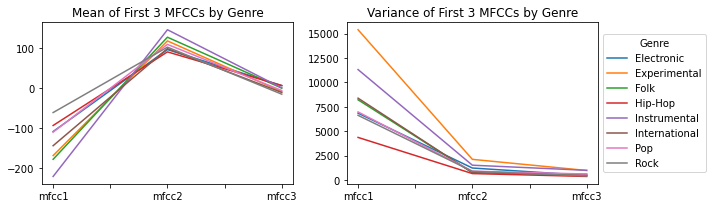

In [5]:
mfcc_cols = [f'mfcc{i}' for i in range(1,4)]
mfcc_by_genre = df[mfcc_cols + ['genre']].groupby('genre')
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
mfcc_by_genre.mean().transpose().plot(ax=axes[0])
axes[0].set_title('Mean of First 3 MFCCs by Genre')
axes[0].get_legend().remove()
mfcc_by_genre.var().transpose().plot(ax=axes[1])
axes[1].set_title('Variance of First 3 MFCCs by Genre')
axes[1].legend(title='Genre', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

Above, we plot only the first three MFCCs by genre. The first MFCC was fairly distinct for each genre with a high variance. However, the higher MFCCs have almost no variance and a very similar mean for each genre. We conclude that the earlier MFCCs are more important for classification.

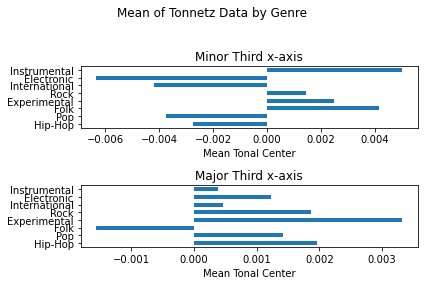

In [6]:
# Load the data and get the labels
data = pd.read_csv('./../data/features.csv', index_col=0)

# Save the genre labels
genre_labels = ["Hip-Hop", "Pop", "Folk", "Experimental", "Rock", "International", "Electronic", "Instrumental"]
tonnetz_labels = ['Fifth x-axis', 'Fifth y-axis', 'Minor Third x-axis', 'Minor Third y-axis', 'Major Third x-axis', 'Major Third y-axis']

# Get the tonnetz features in their own dataframe and group by genre
tonnetz_features = data[['genre_code', 'tonnetz1', 'tonnetz2', 'tonnetz3', 'tonnetz4', 'tonnetz5', 'tonnetz6', 'tonnetz7', 'tonnetz8', 'tonnetz9', 'tonnetz10', 'tonnetz11', 'tonnetz12']]    
group = tonnetz_features.groupby('genre_code')

# Make some bar plots
fig, ax = plt.subplots(2, 1)
group.mean()['tonnetz' + str(5)].plot(kind='barh', ax=ax.reshape(-1)[0])
ax.reshape(-1)[0].set_yticklabels(genre_labels)
ax.reshape(-1)[0].set_xlabel('Mean Tonal Center')
ax.reshape(-1)[0].set_ylabel('')
ax.reshape(-1)[0].set_title(str(tonnetz_labels[2]))
group.mean()['tonnetz' + str(9)].plot(kind='barh', ax=ax.reshape(-1)[1])
ax.reshape(-1)[1].set_yticklabels(genre_labels)
ax.reshape(-1)[1].set_xlabel('Mean Tonal Center')
ax.reshape(-1)[1].set_ylabel('')
ax.reshape(-1)[1].set_title(str(tonnetz_labels[4]))
plt.suptitle('Mean of Tonnetz Data by Genre\n')
plt.tight_layout()
plt.show()

For each tonnetz, we calculated the mean and variance of the x and y directions for that tonal center for each song.  Above are the plots of the averages of two of those means across each genre. We show plots of the major and minor third x-axis means, and much of the other data behaves similarly.  Which tones are positive and negative changes for each tone, indicating that the mean tonal center data could be useful in making decisions between genres. 

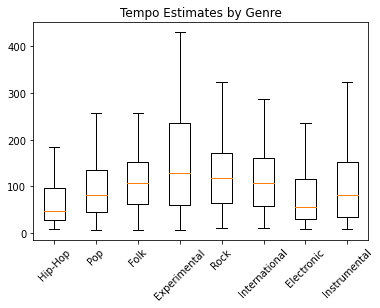

In [7]:
genre_labels = ["Hip-Hop", "Pop", "Folk", "Experimental", "Rock", "International", "Electronic", "Instrumental"]
data = pd.read_csv('./../data/features.csv', index_col=0)
tempo_features = data['tempo1']
plt.boxplot(np.array([
    tempo_features[data['genre_code'] == i] for i in range(len(genre_labels))
], dtype=object), labels=genre_labels, showfliers=False)
plt.xticks(rotation=45)
plt.title('Tempo Estimates by Genre')
plt.show()

The tempo estimates are all somewhat similar in shape, in that all are skewed toward the lower end of the tempo ranges and all have outliers in the higher tempo ranges. We do see, however, that electronic and hip-hop songs appear to have a stronger clustering of tempo estimates at the lower/slower end of the spectrum, which could indicate that the tempo data may be useful for classification.  

We note that we are ignoring the outliers to focus more on the distribution of the tempo estimates; some of the outliers had values as high as 1200. That may indicate that the algorithm failed to pick out a tempo for these songs, or that some of the experimental music doesn't have a tempo.

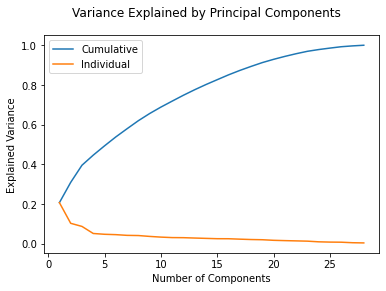

In [8]:
scree_plot()

Using principal component analysis, we see that most of the variation in our features (90%) are explained by about 20 components.  There is a strong dropoff in the amount of variance explained by each individual component after about the fourth component, seen in the scree plot (orange). Because we only had about 30 features, we decided to use the original features in our models, rather than the principal components.

## Models

We trained each of the models we learned in class on our engineered features; the results are below. We have also included the code for our random forest model, which we found performed the best.

```python
def random_forest(
        filename="../data/features.csv", test_size=0.3, plot_matrix=False, normalize=True,
        print_feature_importance=False
):
    df = pd.read_csv(filename, index_col=0)
    x = preprocessing.scale(df.drop(["track_id", "genre_code"], axis=1))
    y = df["genre_code"]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, stratify=y)

    params = {"n_estimators": 1000}

    clf = RandomForestClassifier()
    clf.set_params(**params)
    clf.fit(x_train, y_train)

    if print_feature_importance:
        # get feature importance
        features = df.drop(["track_id", "genre_code"], axis=1).columns
        imp = clf.feature_importances_
        sorted_features = np.argsort(imp)

        print("Most-Important:", [features[i] for i in sorted_features[-3:]])
        print("Least-Important:", [features[i] for i in sorted_features[:3]])

    predictions = clf.predict(x_test)
    # print(
    #     "RF Accuracy:",
    #     (len(y_test) - np.count_nonzero(predictions - y_test)) / len(y_test),
    # )

    if plot_matrix:
        plot_confusion_matrix(y_test, predictions, genres, normalize=normalize, title="Random Forest Confusion Matrix")

    return clf
```

### Table of Accuracy

| Model | Accuracy |
|-------|----------|
|Logistic Regression  |44%          |
|XGBoost              |49%          |
|Random Forest        |53%          |
|Multilayer Perceptron|43%          |
|K-nearest Neighbors  |40%          |

Among the models we trained on the features, XGBoost and random forests (with around 1000 trees) had the highest accuracy.

The confusion matrix below tells us that pop is misidentified most of the time, whereas hip-hop is classified correctly the majority of the time. We can conclude that even though the overall accuracy is low, this is largely due to a couple genres.

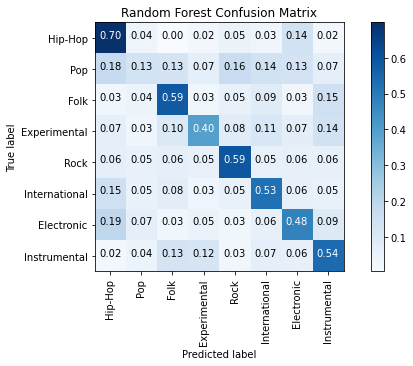

In [9]:
# random forest
plt.rcParams['figure.figsize'] = 8, 5
a = random_forest(plot_matrix=True);

### Answering Questions

Our main research question is finding out what features help identify a genre. We found out which features were most and least important in our random forest (our best classifier), which seems to help indicate which of the features we developed are actually helpful in classifying songs by genre. We found that the most important features were the minimum frequency, the second MFCC coefficient, the maximum freq, the first MFCC coefficient, and the first tempo estimate. The least important features were the major, the key, and some of the tonnetz features.

Which features are not important is just as interesting as which features are important. Significantly, major, key, and tonality (tonnetz) are pretty useless for classifying by genre, indicating that all genres cover a similarly wide array of majors, keys, and tonalities.

Heuristically, the MFCC coefficients should mimic for the computer the way that we as humans interpret music, and it is interesting that these were ranked so high for importance in classification. The max and min frequencies were also important, as well as the tempos (i.e. some genres have more fast vs. slow songs, and the range of frequencies included in a given song actually do help classify it by genre).

# Conclusion

Overall, we found tree-based methods to be most effective for this problem, which outperformed linear regression and k-nearest neighbors. We didn't achieve the state of the art accuracy seen by others (around 70%) when using classical machine learning methods, and we fell far short of the accuracy achieved when using neural networks. Neural networks can be trained on the raw audio or the full MFCCs to achieve around 80%-90% accuracy.

One reason our accuracy is not as high as that seen by others may be our engineered features. Rather than using all the data available, in order to make the problem more tractable, we condensed the features (for example, by training on the mean of the MFCCs). As it was, the features already took a long time to process on our machines.

Additionally, genre is to a large degree subjective, and each genre contains many subgenres. Also, many songs belong to more than one genre; for example, pop as a genre is very broad. Some of our misclassified songs may have actually been right, but the labels could have been wrong or multiple labels could have applied. Thus, perfect accuracy can't be expected to be attained on this problem.

Music classification is hard; it may be better suited to deep learning methods rather than classical machine learning methods.

# Bibliography

(1) G. Tzanetakis and P. Cook. Musical genre classification of audio signals. IEEE Transactions on Speech and Audio Processing, 10(5):293–302, July 2002.

(2) D. Perrot and R. Gjerdigen, “Scanning the dial: An exploration of factors in identification of musical style,” in Proc. Soc. Music Perception
Cognition, 1999, p. 88

(3) Mingwen Dong. Convolutional neural network achieves human-level accuracy in music genre classification. CoRR, abs/1802.09697, 2018